In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

In [2]:
df = pd.read_csv('../agent/cleaned_data/COOP.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1/2/2013,10.20,10.32,9.48,9.72,9.72,64700
1,1/3/2013,9.60,9.84,9.48,9.60,9.60,21600
2,1/4/2013,9.48,9.96,9.48,9.48,9.48,8000
3,1/7/2013,9.48,9.60,9.00,9.36,9.36,116100
4,1/8/2013,9.48,9.48,7.80,8.40,8.40,20800


In [3]:
class Agent:

    LEARNING_RATE = 1e-4
    LAYER_SIZE = 256
    GAMMA = 0.9
    OUTPUT_SIZE = 3

    def __init__(self, state_size, window_size, trend, skip):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.X = tf.placeholder(tf.float32, (None, self.state_size))
        self.REWARDS = tf.placeholder(tf.float32, (None))
        self.ACTIONS = tf.placeholder(tf.int32, (None))
        feed_forward = tf.layers.dense(self.X, self.LAYER_SIZE, activation = tf.nn.relu)
        self.logits = tf.layers.dense(feed_forward, self.OUTPUT_SIZE, activation = tf.nn.softmax)
        input_y = tf.one_hot(self.ACTIONS, self.OUTPUT_SIZE)
        loglike = tf.log((input_y * (input_y - self.logits) + (1 - input_y) * (input_y + self.logits)) + 1)
        rewards = tf.tile(tf.reshape(self.REWARDS, (-1,1)), [1, self.OUTPUT_SIZE])
        self.cost = -tf.reduce_mean(loglike * (rewards + 1)) 
        self.optimizer = tf.train.AdamOptimizer(learning_rate = self.LEARNING_RATE).minimize(self.cost)
        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())
    
    def predict(self, inputs):
        return self.sess.run(self.logits, feed_dict={self.X:inputs})
    
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])
    
    def discount_rewards(self, r):
        discounted_r = np.zeros_like(r)
        running_add = 0
        for t in reversed(range(0, r.size)):
            running_add = running_add * self.GAMMA + r[t]
            discounted_r[t] = running_add
        return discounted_r
    
    def get_predicted_action(self, sequence):
        prediction = self.predict(np.array(sequence))[0]
        return np.argmax(prediction)
    
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.get_predicted_action(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and initial_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
                
                
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            
            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
        
    
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            ep_history = []
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.get_predicted_action(state)
                next_state = self.get_state(t + 1)
                if action == 1 and starting_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                    inventory.append(self.trend[t])
                    starting_money -= close[t]
                
                elif action == 2 and len(inventory):
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                ep_history.append([state,action,starting_money,next_state])
                state = next_state
            ep_history = np.array(ep_history)
            ep_history[:,2] = self.discount_rewards(ep_history[:,2])
            cost, _ = self.sess.run([self.cost, self.optimizer], feed_dict={self.X:np.vstack(ep_history[:,0]),
                                                    self.REWARDS:ep_history[:,2],
                                                    self.ACTIONS:ep_history[:,1]})
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [4]:
close = df.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1
agent = Agent(state_size = window_size,
             window_size = window_size,
             trend = close,
             skip = skip)
agent.train(iterations = 200, checkpoint = 10, initial_money = initial_money)

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


C:\Users\Magda\anaconda3\lib\site-packages\ipykernel_launcher.py:107: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


epoch: 10, total rewards: -0.490002.3, cost: -32684.453125, total money: 9999.509998
epoch: 20, total rewards: 5.430007.3, cost: -33161.875000, total money: 10005.430007
epoch: 30, total rewards: 4.340009.3, cost: -33511.582031, total money: 10004.340009
epoch: 40, total rewards: 36.869999.3, cost: -33854.468750, total money: 10023.569999
epoch: 50, total rewards: 45.980001.3, cost: -34128.839844, total money: 9865.440002
epoch: 60, total rewards: 516.599996.3, cost: -35489.476562, total money: 10153.119998
epoch: 70, total rewards: 627.030008.3, cost: -35884.000000, total money: 10139.210009
epoch: 80, total rewards: 719.020018.3, cost: -36192.558594, total money: 10222.390020
epoch: 90, total rewards: 634.500008.3, cost: -36086.296875, total money: 9875.590010
epoch: 100, total rewards: 647.110003.3, cost: -36055.203125, total money: 9692.310004
epoch: 110, total rewards: 613.719998.3, cost: -35911.597656, total money: 9664.940000
epoch: 120, total rewards: 494.729993.3, cost: -35621

In [5]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 0: buy 1 unit at price 9.720000, total balance 9990.280000
day 1: buy 1 unit at price 9.600000, total balance 9980.679999
day 2: buy 1 unit at price 9.480000, total balance 9971.200000
day 3: buy 1 unit at price 9.360000, total balance 9961.840000
day 4: buy 1 unit at price 8.400000, total balance 9953.440001
day 5: buy 1 unit at price 8.040000, total balance 9945.400001
day 6: buy 1 unit at price 8.640000, total balance 9936.760000
day 8, sell 1 unit at price 9.000000, investment -7.407410 %, total balance 9945.760000,
day 9: buy 1 unit at price 9.600000, total balance 9936.160000
day 10, sell 1 unit at price 9.600000, investment 0.000000 %, total balance 9945.760000,
day 12: buy 1 unit at price 9.960000, total balance 9935.800000
day 13: buy 1 unit at price 9.600000, total balance 9926.200000
day 15, sell 1 unit at price 9.960000, investment 5.063297 %, total balance 9936.160000,
day 16, sell 1 unit at price 9.960000, investment 6.410261 %, total balance 9946.120000,
day 17: buy 

day 178, sell 1 unit at price 16.559999, investment 66.265054 %, total balance 9768.640004,
day 179: buy 1 unit at price 16.559999, total balance 9752.080004
day 181: buy 1 unit at price 15.360000, total balance 9736.720005
day 182, sell 1 unit at price 15.360000, investment 54.216863 %, total balance 9752.080004,
day 183: buy 1 unit at price 15.240000, total balance 9736.840004
day 184, sell 1 unit at price 15.000000, investment 48.809525 %, total balance 9751.840004,
day 185, sell 1 unit at price 14.880000, investment 40.909086 %, total balance 9766.720005,
day 186, sell 1 unit at price 14.880000, investment 44.186052 %, total balance 9781.600005,
day 187: buy 1 unit at price 14.640000, total balance 9766.960004
day 193: buy 1 unit at price 14.520000, total balance 9752.440004
day 194: buy 1 unit at price 14.280000, total balance 9738.160004
day 195: buy 1 unit at price 14.160000, total balance 9724.000004
day 198, sell 1 unit at price 14.280000, investment 41.666665 %, total balance

day 350, sell 1 unit at price 34.919998, investment -10.461543 %, total balance 9892.000009,
day 351, sell 1 unit at price 34.919998, investment -10.185192 %, total balance 9926.920007,
day 352: buy 1 unit at price 34.799999, total balance 9892.120008
day 353, sell 1 unit at price 35.279999, investment -7.836991 %, total balance 9927.400007,
day 355, sell 1 unit at price 34.799999, investment -14.201188 %, total balance 9962.200006,
day 356, sell 1 unit at price 34.680000, investment -12.158053 %, total balance 9996.880006,
day 358: buy 1 unit at price 33.119999, total balance 9963.760007
day 359: buy 1 unit at price 33.840000, total balance 9929.920007
day 362, sell 1 unit at price 34.080002, investment -13.939386 %, total balance 9964.000009,
day 365: buy 1 unit at price 35.759998, total balance 9928.240011
day 368, sell 1 unit at price 33.959999, investment -14.242423 %, total balance 9962.200010,
day 369: buy 1 unit at price 33.599998, total balance 9928.600011
day 370: buy 1 unit 

day 519: buy 1 unit at price 25.799999, total balance 10064.320018
day 520: buy 1 unit at price 25.920000, total balance 10038.400018
day 521, sell 1 unit at price 26.160000, investment 8.999999 %, total balance 10064.560018,
day 527, sell 1 unit at price 25.799999, investment 6.965167 %, total balance 10090.360017,
day 529: buy 1 unit at price 26.400000, total balance 10063.960018
day 531, sell 1 unit at price 26.400000, investment 9.452731 %, total balance 10090.360017,
day 532, sell 1 unit at price 26.400000, investment 8.910891 %, total balance 10116.760017,
day 533: buy 1 unit at price 26.400000, total balance 10090.360017
day 534, sell 1 unit at price 26.040001, investment 11.282057 %, total balance 10116.400018,
day 535: buy 1 unit at price 26.400000, total balance 10090.000019
day 536, sell 1 unit at price 26.160000, investment 14.736845 %, total balance 10116.160019,
day 539, sell 1 unit at price 26.400000, investment 2.803736 %, total balance 10142.560018,
day 540, sell 1 uni

day 702: buy 1 unit at price 29.520000, total balance 10105.600010
day 703: buy 1 unit at price 30.000000, total balance 10075.600010
day 704, sell 1 unit at price 29.639999, investment -1.593630 %, total balance 10105.240009,
day 705: buy 1 unit at price 29.160000, total balance 10076.080009
day 707: buy 1 unit at price 29.400000, total balance 10046.680009
day 708, sell 1 unit at price 29.280001, investment -3.174600 %, total balance 10075.960010,
day 710: buy 1 unit at price 28.799999, total balance 10047.160011
day 711, sell 1 unit at price 28.440001, investment -4.435483 %, total balance 10075.600011,
day 712, sell 1 unit at price 28.440001, investment -8.846154 %, total balance 10104.040012,
day 714: buy 1 unit at price 28.200001, total balance 10075.840011
day 715: buy 1 unit at price 27.959999, total balance 10047.880012
day 716, sell 1 unit at price 28.080000, investment -7.142857 %, total balance 10075.960012,
day 719: buy 1 unit at price 28.200001, total balance 10047.760011

day 881, sell 1 unit at price 26.879999, investment -1.754391 %, total balance 9799.240003,
day 883, sell 1 unit at price 27.000000, investment -1.315792 %, total balance 9826.240003,
day 885, sell 1 unit at price 26.760000, investment 1.826482 %, total balance 9853.000003,
day 889, sell 1 unit at price 27.000000, investment 0.896860 %, total balance 9880.000003,
day 890, sell 1 unit at price 27.000000, investment 0.000000 %, total balance 9907.000003,
day 891: buy 1 unit at price 27.600000, total balance 9879.400003
day 895: buy 1 unit at price 27.480000, total balance 9851.920004
day 896, sell 1 unit at price 27.120001, investment -1.310039 %, total balance 9879.040004,
day 897: buy 1 unit at price 27.719999, total balance 9851.320005
day 899, sell 1 unit at price 29.160000, investment 6.113538 %, total balance 9880.480005,
day 902: buy 1 unit at price 28.799999, total balance 9851.680006
day 903, sell 1 unit at price 29.040001, investment 6.140352 %, total balance 9880.720007,
day 9

day 1062, sell 1 unit at price 15.600000, investment -21.212116 %, total balance 9539.080002,
day 1063, sell 1 unit at price 16.200001, investment -20.588230 %, total balance 9555.280003,
day 1065: buy 1 unit at price 15.960000, total balance 9539.320003
day 1066, sell 1 unit at price 15.600000, investment -25.714284 %, total balance 9554.920004,
day 1067: buy 1 unit at price 15.960000, total balance 9538.960003
day 1068, sell 1 unit at price 16.799999, investment -17.647061 %, total balance 9555.760003,
day 1070: buy 1 unit at price 17.160000, total balance 9538.600003
day 1071, sell 1 unit at price 17.400000, investment -14.705883 %, total balance 9556.000002,
day 1072, sell 1 unit at price 17.760000, investment -4.516130 %, total balance 9573.760003,
day 1073: buy 1 unit at price 18.000000, total balance 9555.760003
day 1074, sell 1 unit at price 18.600000, investment 3.333335 %, total balance 9574.360003,
day 1076, sell 1 unit at price 18.360001, investment 10.869572 %, total balan

day 1233, sell 1 unit at price 8.640000, investment -39.999996 %, total balance 9770.920005,
day 1234, sell 1 unit at price 8.640000, investment -33.333331 %, total balance 9779.560005,
day 1236, sell 1 unit at price 9.000000, investment -28.571431 %, total balance 9788.560005,
day 1237, sell 1 unit at price 9.360000, investment -17.894737 %, total balance 9797.920005,
day 1238: buy 1 unit at price 10.080000, total balance 9787.840005
day 1239: buy 1 unit at price 11.520000, total balance 9776.320005
day 1240, sell 1 unit at price 10.920000, investment -8.999999 %, total balance 9787.240005,
day 1241: buy 1 unit at price 10.320000, total balance 9776.920005
day 1242: buy 1 unit at price 10.440000, total balance 9766.480005
day 1244, sell 1 unit at price 10.800000, investment -4.255315 %, total balance 9777.280006,
day 1248: buy 1 unit at price 9.480000, total balance 9767.800006
day 1249: buy 1 unit at price 8.880000, total balance 9758.920006
day 1251: buy 1 unit at price 8.640000, to

day 1386: buy 1 unit at price 16.920000, total balance 9665.320006
day 1387, sell 1 unit at price 16.920000, investment 0.000000 %, total balance 9682.240007,
day 1388, sell 1 unit at price 16.680000, investment -2.797200 %, total balance 9698.920007,
day 1389, sell 1 unit at price 16.680000, investment 0.000000 %, total balance 9715.600007,
day 1392, sell 1 unit at price 16.440001, investment -2.142850 %, total balance 9732.040008,
day 1394: buy 1 unit at price 16.559999, total balance 9715.480008
day 1395: buy 1 unit at price 16.559999, total balance 9698.920009
day 1397: buy 1 unit at price 16.799999, total balance 9682.120010
day 1399, sell 1 unit at price 17.639999, investment 5.755390 %, total balance 9699.760009,
day 1400: buy 1 unit at price 17.520000, total balance 9682.240008
day 1406: buy 1 unit at price 16.440001, total balance 9665.800008
day 1407, sell 1 unit at price 15.960000, investment -3.623185 %, total balance 9681.760008,
day 1409, sell 1 unit at price 15.960000, i

day 1565, sell 1 unit at price 10.070000, investment -11.975524 %, total balance 9703.140008,
day 1566, sell 1 unit at price 9.610000, investment -18.003418 %, total balance 9712.750008,
day 1567: buy 1 unit at price 9.610000, total balance 9703.140008
day 1568, sell 1 unit at price 9.690000, investment -28.750005 %, total balance 9712.830008,
day 1571, sell 1 unit at price 9.510000, investment -32.553192 %, total balance 9722.340008,
day 1573, sell 1 unit at price 9.340000, investment -37.691793 %, total balance 9731.680008,
day 1577: buy 1 unit at price 9.220000, total balance 9722.460008
day 1580: buy 1 unit at price 8.770000, total balance 9713.690007
day 1582, sell 1 unit at price 9.210000, investment -38.353412 %, total balance 9722.900007,
day 1584, sell 1 unit at price 8.560000, investment -44.379466 %, total balance 9731.460008,
day 1585, sell 1 unit at price 8.380000, investment -44.686467 %, total balance 9739.840008,
day 1586, sell 1 unit at price 8.580000, investment -44.2

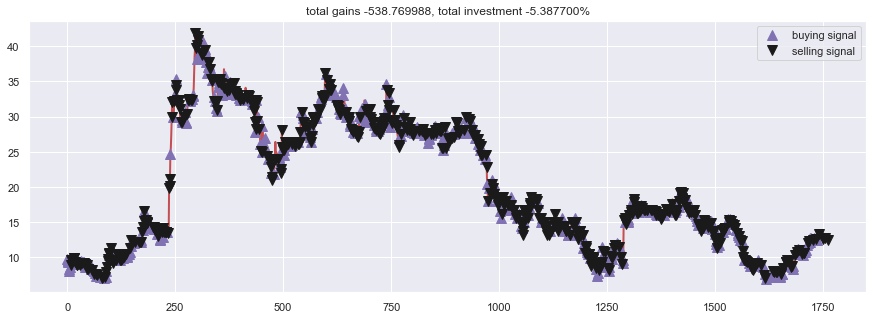

In [6]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()